<a href="https://colab.research.google.com/github/YinterestingProjects/human-wildlife-interactions/blob/main/notebooks/BERTopics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
! pip install pandas==1.4.2 bertopic==0.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import pickle
import pandas as pd
from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer

RANDOM_SEED = 42

In [22]:
# directory setup
user = "sally"
#user = "jina"
#user = "josh"
     
try:
  if user == "sally":
    directory = '/content/drive/MyDrive/MADS/MADS_Capstone'
  elif user == "jina":
    directory = "JINA: INSERT YOUR PATH HERE"
  elif user == "josh":
    directory = "/content/drive/MyDrive/MADS_Capstone"
except:
  dprint("No user has been selected")


In [23]:
def filter_null(df, verbose=True):
    '''filter null translations'''
    clean_corp = df[(df != ' ') & (df != '') & (df != 'source language unavailable for translation')]  
    if verbose:
        print(f'{len(df) - len(clean_corp)} null records dropped out of {len(df)}')  
    return clean_corp

In [30]:
fp = f'{directory}/data/processed/desc_title_translated.pkl'
corpus = pd.read_pickle(fp)
  
order = corpus.index
new_doc = filter_null(corpus['title_en']).reset_index()
docs = new_doc['title_en']
docs

26 null records dropped out of 3895


0                   Observer 22: Autumn on a Beaver's Dam
1           Babies and Otocyons in the Domaine des Fauves
2        Two Giraffe Calves born at the San Francisco Zoo
3       Fauna salbatica bucovineana in fotografi - Buk...
4       Wyoming Archery Mule Deer Hunt With Joe Thomas...
                              ...                        
3864            Outside with the Animals Vol. 2 (October)
3865                   Roaring Lion at the Brookfield Zoo
3866    El Parque Cruz - Aventura Sudáfrica Canal Offi...
3867                Lion Safari Tour @ Gir Forest Gujarat
3868                   Attica - In Parness with the Elves
Name: title_en, Length: 3869, dtype: object

In [82]:
train = True
model_fp = f'{directory}/models/bertopic_guided'

if train: 
  umap_model = UMAP(random_state=RANDOM_SEED)
  tf_vectorizer = CountVectorizer(#preprocessor=custom_preprocessor,
                                  #max_features = 20000, # only top 10k by freq
                                       lowercase = True, # capitalization
                                       ngram_range = (2,3), # include 2-word phrases
                                       min_df=1,  # occur in absolute count of doc
                                       max_df=0.90,   # % of docs
                                       stop_words='english') # default English stopwords
  
  hunting_related_terms = ['hunting', 'trophy', 'rifle', 'trap']
  zoo_related_terms = ['zoo', 'exhibit', 'conservation', 'visit']
  safari_related_terms = ['game drive', 'wildlife photography', 'bush walk', 'safari lodge']
  seed_topic_list = [hunting_related_terms, zoo_related_terms, safari_related_terms]
  
  topic_model = BERTopic(umap_model=umap_model, vectorizer_model=tf_vectorizer, seed_topic_list=seed_topic_list)
  topics, probs = topic_model.fit_transform(docs)
  topic_model.save(model_fp)
else:
  topic_model = BERTopic.load(model_fp)

In [83]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1126,-1_national park_fishermans fishermans_bear hu...
1,0,227,0_asahiyama zoo_zoo asahiyama zoo_zoo asahiyam...
2,1,190,1_deer hunt_deer hunting_mule deer_bow hunting
3,2,175,2_amsterdamse bos_caccia al cinghiale_en el_la...
4,3,174,3_national park_film studio_film studio aves_s...
...,...,...,...
56,55,12,55_eurasian lynx_cat bird_331 cat_lynx canadia...
57,56,11,56_2011 hippo_hippo taking_mar 2011 hippo_pygm...
58,57,11,57_amazing interaction_kitchen waiting_peninsu...
59,58,10,58_hunting russia_bighorns hunting_seek winter...


In [84]:
topic_model.visualize_topics()

In [85]:
topic_model.visualize_barchart(top_n_topics=75, n_words=10)

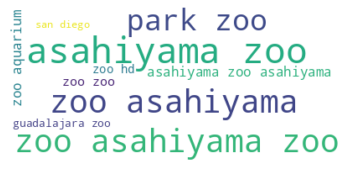

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [87]:
topic_model.visualize_heatmap()

In [88]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 59/59 [00:00<00:00, 88.84it/s]


In [89]:
def search_topics(query, top_N_wrds):
  similar_topics, similarity = topic_model.find_topics(query, top_n=top_N_wrds)

  for i, topic_n in enumerate(similar_topics):
    print(f'\ntopic {topic_n}, similiarity level: {similarity[i]:.3f}')
    print([(wrd, round(score,2)) for wrd, score in topic_model.get_topic(topic_n)])


search_topics('hunting', top_N_wrds=5)


topic 1, similiarity level: 0.855
[('deer hunt', 0.03), ('deer hunting', 0.02), ('mule deer', 0.02), ('bow hunting', 0.02), ('bow hunt', 0.01), ('mule deer hunt', 0.01), ('archery hunt', 0.01), ('whitetail deer', 0.01), ('hog hunt', 0.01), ('archery deer', 0.01)]

topic 58, similiarity level: 0.781
[('hunting russia', 0.15), ('bighorns hunting', 0.08), ('seek winter coyote', 0.08), ('serbia movie coyote', 0.08), ('ungarn hunting', 0.08), ('serbia movie', 0.08), ('visits site', 0.08), ('visits site shy', 0.08), ('wildfish hunting', 0.08), ('wildfish hunting woodcock', 0.08)]

topic 59, similiarity level: 0.741
[('hunting 2012', 0.11), ('2009 north', 0.07), ('trained hunting', 0.07), ('river outdoors', 0.07), ('tom smith', 0.07), ('tail slap', 0.07), ('team taggedout', 0.07), ('tail slap iron', 0.07), ('run 2015', 0.07), ('hunting bc', 0.07)]

topic -1, similiarity level: 0.685
[('national park', 0.0), ('fishermans fishermans', 0.0), ('bear hunt', 0.0), ('fishermans fishermans fisherman